# Dataset Loading

First we will load in the dataset. We will drop the first column of the data and the labels because it contains the name of the samples while we only want to keep the features.

In [1]:
import pandas as pd
import numpy as np
# set global random eed
np.random.seed(42)

# reading the dataset and dropping the sample names column
X = pd.read_csv('Data/data.csv')
X.drop(X.columns[0], axis=1, inplace=True)
y = pd.read_csv('Data/labels.csv')
y.drop(y.columns[0], axis=1, inplace=True)
y = y.squeeze()

# Problem 1

Since `Purity` is not a scikit-learn predefined metris for k-means, we need to define it first manually.

Given some set of clusters M and some set of classes D, both partitioning N data points, purity can be defined as:

$$\text{Purity} = \frac{1}{N}\sum_{m\in M}\max_{d\in D}|m\cap d|$$


In [2]:
from sklearn import metrics

def purity(y_true, y_pred):
    cont_mat = metrics.cluster.contingency_matrix(y_true, y_pred)
    # find the maximum in each row, sum all the maximums and divide by the sum
    # of all of the numbers in the contingency matrix
    return np.sum(np.amax(cont_mat, axis=0)) / np.sum(cont_mat)

## Fitting K-means with $k=5$

We will define a function called `k_means` here that randomly restarts the K-means algorithm `num_runs` times and returns the instance with the lowest inertia to make more-or-less sure that we are close to the global optimum of the K-means loss function surface.

In [3]:
from sklearn.cluster import KMeans
def k_means(X, n_clusters, num_runs, return_pred=False):
    """Run k-means `num_runs` times and return the clustering with the lowest inertia"""
    best_inertia = np.inf
    best_k_means = None
    for i in range(num_runs):
        # running kmeans with init='random' ensures that we get different
        # initial conditions on each run. Every time, 'n_cluster' random points
        # from the samples are chosen as cluster centroids.
        k_means = KMeans(n_clusters=n_clusters, init='random',).fit(X)
        # score returns negative of inertia
        clustering_loss = -k_means.score(X)
        if clustering_loss < best_inertia:
            best_inertia = clustering_loss
            best_k_means = k_means
    if return_pred:
        return best_inertia, best_k_means, best_k_means.predict(X)
    else:
        return best_inertia, best_k_means

## Metrics

In [4]:
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_mutual_info_score as AMI

inertia, kmeans_obj, y_pred_k_means = k_means(X, 5, 10, return_pred=True)
print(f'Best clustering loss achieved: {inertia}')
print(f'ARI: {ARI(y, y_pred_k_means)}')
print(f'NMI: {NMI(y, y_pred_k_means)}')
print(f'AMI: {AMI(y, y_pred_k_means)}')
print(f'Purity: {purity(y, y_pred_k_means)}')

Best clustering loss achieved: 17801949.109766014
ARI: 0.9813802804214912
NMI: 0.9720313245430697
AMI: 0.9718429200528593
Purity: 0.9925093632958801


As we can see, and since we knew the number of clusters beforehand (5 categories of cancer genes), Purity, ARI and NMI scores are all very high.
The clustering loss may seem like a large number, but we have to keep in mind that the clustering loss is a relative metric. It needs to be compared with the smallest possible value that it can take, which is unknown which renders it useless as an absolute metric unlike Purity, ARI and NMI.

# Problem 2

We will run the k-means algorithm for $k=3$ through $k=7$ with an analysis of the silhouette score to see which $k$ value performs best. From the scores we have seen in the previous problem we expect that $k=5$ yields the best results.

For k = 3, the average silhouette score is: 0.16914531089163637
For k = 4, the average silhouette score is: 0.2012793241489044
For k = 5, the average silhouette score is: 0.2246929336121643
For k = 6, the average silhouette score is: 0.2287560480963709
For k = 7, the average silhouette score is: 0.1795351532867552


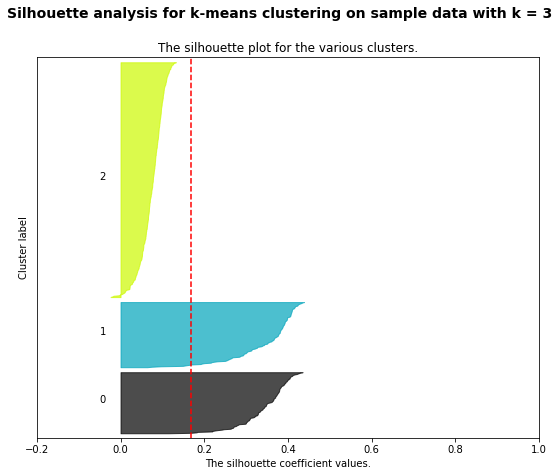

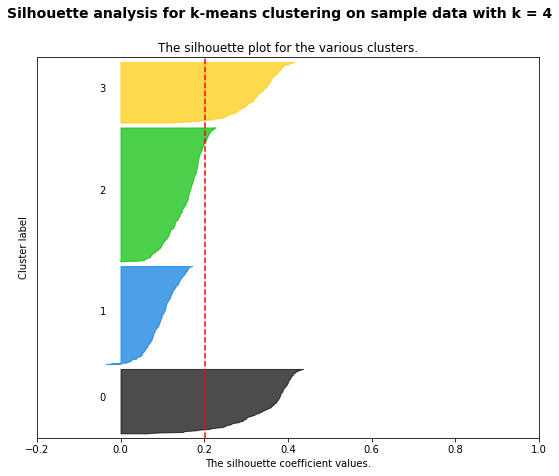

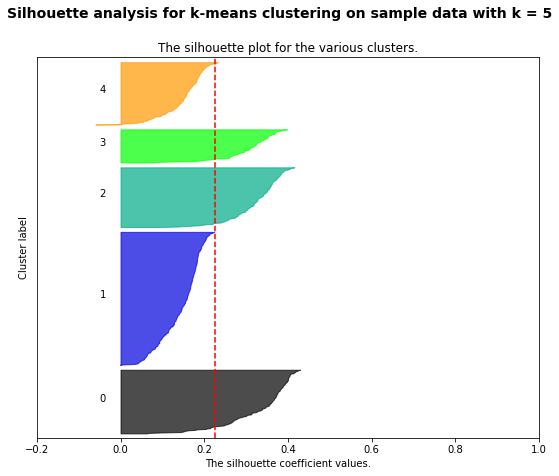

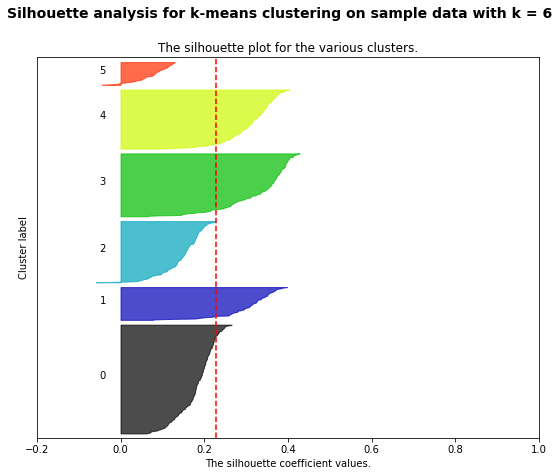

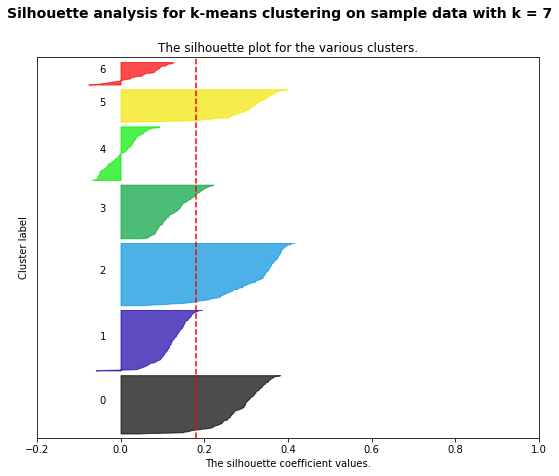

In [5]:
# implementation taken from scikit-learn:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
range_n_clusters = range(3, 8)
for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 7)
    ax.set_xlim([-0.2, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    _, clusterer, cluster_labels = k_means(X, n_clusters, 10, return_pred=True)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'For k = {n_clusters}, the average silhouette score is: {silhouette_avg}')
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i)/n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        ax.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values.")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax.set_yticks([])
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(
        f"Silhouette analysis for k-means clustering on sample data with k = {n_clusters}",
        fontsize=14,
        fontweight='bold'
    )
plt.show()

Looking at the plots above, it seems that $k=5$ is indeed the best choice for this dataset as none of the clusters have fallen completely behind the average line. Although $k=6$ yields a marginally better average silhouette score, we can see that cluster with label 5 falls entirely below the average line which is not a desirable property for a good clustering.

# Problem 3

GMM is able to perform more complex clusterings due to the fact that it is no longer bound to diagonal covariance matrices for the Gaussians. However, the tradeoff is that it is arguably more complex. Overall, it is expected that GMM provides better clustering results than k-means.

## Fitting a GMM with 5 components on the dataset

Since the feature space for this dataset is extremely large, GMM requires an infeasible amount of memory on the original feature space. Therefore, we will reduce the dimensionality of the feature space through PCA first that preserves 99% of the information in the dataset.

In [6]:
from sklearn.decomposition import PCA
print(f'Number of features before PCA: {X.shape[1]}')
X_pca = PCA(0.99).fit_transform(X)
print(f'Number of features after a 99% preserving PCA: {X_pca.shape[1]}')

Number of features before PCA: 20531
Number of features after a 99% preserving PCA: 704


As we can see the number of features has decreased by a very sizeable margin with minimal loss of information. We are now able to fit a GMM on the dataset.

In [7]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, max_iter=1000).fit(X_pca)
y_pred_gm = gm.predict(X_pca)

## Metrics

In [8]:
print(f'ARI: {ARI(y, y_pred_gm)}')
print(f'NMI: {NMI(y, y_pred_gm)}')
print(f'AMI: {AMI(y, y_pred_gm)}')

ARI: 0.9863901021237802
NMI: 0.9764242999751586
AMI: 0.9762655900687124


As we can see, GMM performs marginally better than K-means here according to the ARI, NMI and AMI metrics. And since we have kept 99% of the information through PCA, it is unlikely that the 1% loss is responsible for how small this margin of improvement is.

A more likely scenario here is that the dataset had naturally well-formed compact clusters where the eigenvalues covariance matrices of each of the clusters are almost the same, which is the case where GMM and K-means reach very similar clusterings. ($\Sigma = \sigma^2 I$)

# Problem 4

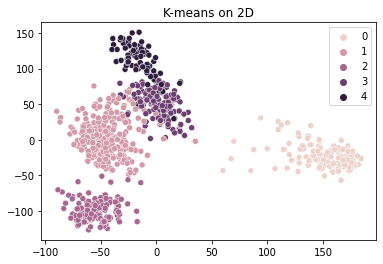

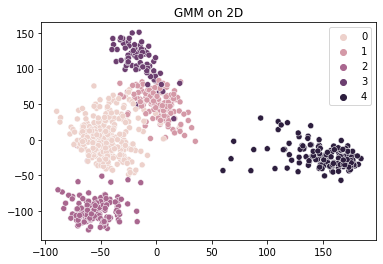

In [9]:
from seaborn import scatterplot
X_pca_2 = PCA(n_components=2).fit_transform(X)
ax1 = scatterplot(x=X_pca_2[:,0], y=X_pca_2[:,1], hue=y_pred_k_means, cmap='plasma')
ax1.set_title('K-means on 2D')
plt.show()
ax2 = scatterplot(x=X_pca_2[:,0], y=X_pca_2[:,1], hue=y_pred_gm, cmap='plasma')
ax2.set_title('GMM on 2D')
plt.show()

As we can see, the clusterings produced by both methods are almost identical which matches our expectations from the results of the previous problem. Another thing to keep in mind is that these plots are the cluster labels trained on a much higher dimensional feature space, displayed in 2D. This explains why the projection of K-means in 2D contains samples which are very far into another cluster but with are labeled differently.